GPLVM
--
This notebook shows how to build GPLVM model.

In [8]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize

In [9]:
data = pods.datasets.oil_100()

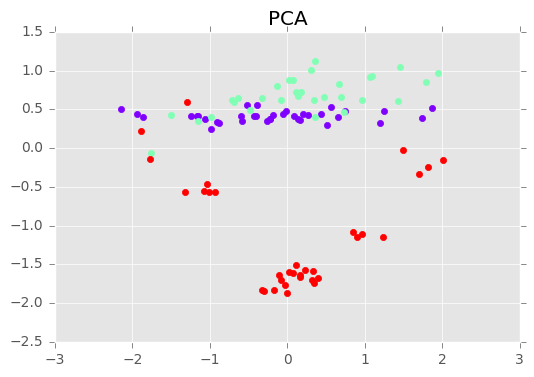

In [13]:
# import matplotlib.cm as cm
Y = data['X']
XPCA = GPflow.gplvm.PCA_reduce(data['X'], 2)
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
for i, c in zip(np.unique(labels), colors):
    plt.scatter(XPCA[labels==i,0], XPCA[labels==i,1], color=c, label=i)
plt.title('PCA')

### Model construction

Create Bayesian GPLVM model.

In [17]:
Q = 6
M = 10  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=[0,1,2]),
                  ekernels.Linear(3, active_dims=[3,4,5])])
# kernels.PeriodicKernel(1, active_dims=[1])])
Z = np.random.permutation(X_mean.copy())[:M]
m = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

In [18]:
m.optimize(display=True)

ValueError: Cannot create a tensor proto whose content is larger than 2GB.

In [ ]:
# Plot ARD weights to pick which dimensions to plot

0
1
2


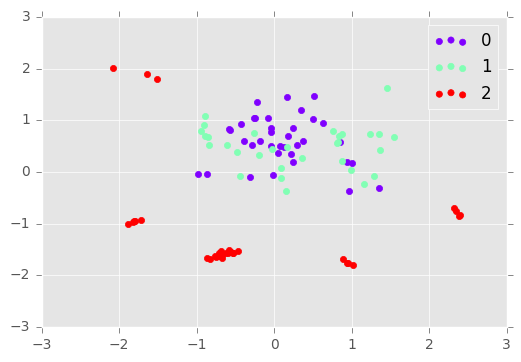

In [53]:
# plot
for i, c in zip(np.unique(labels), colors):
    plt.scatter(m.X_mean.value[labels==i,0], m.X_mean.value[labels==i,1], color=c, label=i)
plt.legend()